## Sổ tay Tác nhân RL (Đã sửa lỗi)

Sổ tay này tải môi trường, cấu hình GNN, và trọng số GNN đã huấn luyện (từ `Graph_Canonical_50.ipynb`) để chạy Tác nhân DQN.

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import dgl
import os
from copy import deepcopy
from collections import defaultdict
import random

# Giả định các tệp utils này tồn tại trong thư mục của bạn
# (Tệp graph_utils.py phải chứa EGraphSAGE_GraphAlign và DGI_GraphAlign)
from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *

print("--- CHUẨN BỊ MÔI TRƯỜNG ---")

# --- CHỌN PHIÊN BẢN THÍ NGHIỆM ---
experiment_id = 1
BASE_PATH = f'graphs/{experiment_id}'
print(f"Đang chạy thí nghiệm ID: {experiment_id} tại đường dẫn: {BASE_PATH}")

--- CHUẨN BỊ MÔI TRƯỜNG ---
Đang chạy thí nghiệm ID: 1 tại đường dẫn: graphs/1


In [2]:
# ======================================================================
# 1. TẢI DỮ LIỆU MÔI TRƯỜNG TĨNH
# ======================================================================
print("\n--- Đang tải dữ liệu môi trường (tĩnh) ---")
STATIC_FILE_PATH = f"{BASE_PATH}/graph_environment.pth"
NODE_EMB_PATH = f"{BASE_PATH}/node_embeddings.npy"

try:
    env_data = torch.load(STATIC_FILE_PATH, weights_only=False)
    
    G_original = env_data['G_original']
    node_order = env_data['node_order']
    node_map = env_data['node_map']
    
    # Lấy các đặc trưng GỐC (ví dụ: [8, 2])
    original_node_features = env_data['node_features_original']
    original_edge_features = env_data['edge_features_original']
    g1 = env_data['g1'] # Đồ thị DGL gốc
    
    # Lấy cột priority (ví dụ: [8, 1])
    static_priority_features = original_node_features[:, 1].unsqueeze(1) 

    nodes_emb = np.load(NODE_EMB_PATH) # Tải embedding đã huấn luyện

    print(f"Đã tải môi trường tĩnh từ '{STATIC_FILE_PATH}'")
    print(f"Tổng số node: {len(node_order)}")
    print(f"Shape của Node Embeddings (đã huấn luyện): {nodes_emb.shape}")
    print(f"Shape của Đặc trưng Node Gốc: {original_node_features.shape}")

except Exception as e:
    print(f"LỖI: Không tìm thấy hoặc không đọc được tệp môi trường/embedding: {e}")
    print("Vui lòng chạy sổ tay 'Graph.ipynb' (huấn luyện) trước.")


--- Đang tải dữ liệu môi trường (tĩnh) ---
Đã tải môi trường tĩnh từ 'graphs/1/graph_environment.pth'
Tổng số node: 8
Shape của Node Embeddings (đã huấn luyện): (8, 24)
Shape của Đặc trưng Node Gốc: torch.Size([8, 2])


In [3]:
# ======================================================================
# 2. ĐỊNH NGHĨA HÀM TIỀN XỬ LÝ (PHẢI GIỐNG HỆT FILE HUẤN LUYỆN)
# ======================================================================
# (Chúng ta cần các hằng số và hàm này để xử lý
#  đặc trưng [8, 2] thành [8, 50] trước khi đưa vào encoder)

MAX_N_FEATURES = 50
MAX_E_FEATURES = 50
MARKER_VALUE = -999.0

def normalize_and_pad_batch(feats_list, max_dim):
    """
    Hàm này lấy một danh sách các tensor đặc trưng (từ các đồ thị khác nhau),
    đệm chúng lên max_dim, sau đó chuẩn hóa từng cột một cách an toàn.
    """
    padded_tensors = []
    for feats in feats_list:
        num_nodes_or_edges, num_feats = feats.shape
        if num_feats > max_dim:
            raise ValueError(f"Đồ thị có {num_feats} đặc trưng, nhiều hơn MAX={max_dim}")
        
        padded_tensor = torch.full((num_nodes_or_edges, max_dim), MARKER_VALUE, dtype=torch.float32)
        padded_tensor[:, :num_feats] = feats
        padded_tensors.append(padded_tensor)
    
    full_batch_tensor = torch.cat(padded_tensors, dim=0)
    normalized_batch_tensor = full_batch_tensor.clone()
    
    for i in range(max_dim):
        col = full_batch_tensor[:, i]
        valid_mask = (col != MARKER_VALUE)
        
        if valid_mask.any():
            valid_values = col[valid_mask]
            mean = valid_values.mean()
            std = valid_values.std() + 1e-6
            normalized_batch_tensor[valid_mask, i] = (valid_values - mean) / std
            normalized_batch_tensor[~valid_mask, i] = 0.0
        else:
            normalized_batch_tensor[:, i] = 0.0
            
    return normalized_batch_tensor

print("Đã định nghĩa hàm tiền xử lý (padding + normalization).")

Đã định nghĩa hàm tiền xử lý (padding + normalization).


In [4]:
# ======================================================================
# 3. TẢI MODEL GNN ĐÃ HUẤN LUYỆN (PHẦN ĐÃ SỬA)
# ======================================================================
print("\n--- Đang tải cấu hình và trọng số GNN ---")

MODEL_STATE_PATH = f"{BASE_PATH}/dgi_model_state_dict.pth"
CONFIG_FILE_PATH = f"{BASE_PATH}/model_config.pth"

try:
    # --- 3.1: Tải file cấu hình ---
    config = torch.load(CONFIG_FILE_PATH, weights_only=False)
    print(f"Đã tải cấu hình: {config}")

    # --- 3.2: Khởi tạo mô hình rỗng TỪ CẤU HÌNH ĐÃ TẢI ---
    # SỬA: Phải dùng EGraphSAGE_GraphAlign và DGI_GraphAlign
    encoder = EGraphSAGE_GraphAlign(
        config['NDIM_IN'],       # 50
        config['EDIM'],          # 50
        config['N_HIDDEN'],
        config['N_OUT'],
        config['N_LAYERS'],
        F.leaky_relu,
        config['NUM_EXPERTS'],   # Thêm tham số MoF
        config['TOP_K']          # Thêm tham số MoF
    )

    dgi_model_to_load = DGI_GraphAlign(encoder) # SỬA: Dùng DGI_GraphAlign

    # --- 3.3: Tải trọng số đã lưu ---
    dgi_model_to_load.load_state_dict(torch.load(MODEL_STATE_PATH, weights_only=False))

    # --- 3.4: Trích xuất encoder bạn cần ---
    trained_encoder = dgi_model_to_load.encoder
    trained_encoder.eval() # Chuyển sang chế độ dự đoán

    print(f"[THÀNH CÔNG] Đã tải và trích xuất GNN encoder (EGraphSAGE_GraphAlign).")

except Exception as e:
    print(f"\n[LỖI] Có lỗi xảy ra khi tải model: {e}")
    print("Hãy chắc chắn tệp 'graph_utils.py' của bạn chứa 'EGraphSAGE_GraphAlign' và 'DGI_GraphAlign'.")
    trained_encoder = None


--- Đang tải cấu hình và trọng số GNN ---
Đã tải cấu hình: {'NDIM_IN': 50, 'EDIM': 50, 'N_HIDDEN': 16, 'N_OUT': 24, 'N_LAYERS': 2, 'NUM_EXPERTS': 4, 'TOP_K': 1}
[THÀNH CÔNG] Đã tải và trích xuất GNN encoder (EGraphSAGE_GraphAlign).


In [5]:
# ======================================================================
# 4. ĐỊNH NGHĨA LOGIC HUẤN LUYỆN DQN
# ======================================================================
# (Nội dung của 2 cell DQN lớn từ file gốc của bạn)

def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    global best_checkpoint, best_episode
    # 1. Reset env để lấy state (embedding) ban đầu
    state = env.reset() # state giờ là Tensor [num_nodes, embedding_dim]

    # 2. Tính toán state_size đã làm phẳng
    num_nodes = state.shape[0]
    embedding_dim = state.shape[1]
    state_size = num_nodes * embedding_dim  # <--- Kích thước input mới cho DQN

    action_space_size = env.get_action_space_size()

    print('state_size (flattened):', state_size) # <--- Cập nhật log
    print('action_space_size', action_space_size)

    # 3. Khởi tạo DQN với state_size mới
    policy_net = DQN(state_size, action_space_size)
    target_net = DQN(state_size, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = num_episodes // 10
    interval_save = num_episodes // 5
    best_checkpoint = None
    best_episode = 0

    for episode in range(1, num_episodes + 1):
        # Reset state cho các episode sau
        if episode > 1:
            state = env.reset() # <--- state là Tensor embedding

        done = False
        exploration_counter = defaultdict(int)

        while not done:
            if random.random() < epsilon:
                action_idx = sample_valid_index(action_space_size, env.num_honeypot_nodes, exploration_counter)
            else:
                with torch.no_grad():
                    # --- THAY ĐỔI: Flatten state tensor ---
                    # Chuyển [N, D] -> [1, N*D]
                    state_tensor = state.flatten().unsqueeze(0)
                    q_values = policy_net(state_tensor).squeeze(0)

                    # (Logic lọc q_values giữ nguyên)
                    valid_indices = [idx for idx in range(action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
                    valid_q_values = q_values[valid_indices]
                    max_idx_in_valid = torch.argmax(valid_q_values).item()
                    action_idx = valid_indices[max_idx_in_valid]

            action = index_to_action(action_idx, env.num_honeypot_nodes)

            # --- next_state giờ cũng là Tensor embedding ---
            next_state, reward, done, path, captured = env.step(action)
            action_idx = action_to_index(action, env.num_honeypot_nodes)

            # Store experience (state và next_state là Tensors)
            replay_buffer.push(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            if reward == 1:
                dsp += 1

            # Train if enough experiences
            if len(replay_buffer) >= batch_size:
                # --- THAY ĐỔI: Replay buffer giờ trả về Tensors ---
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

                # states_batch là [B, N, D], actions_batch là [B], rewards_batch là [B, 1], ...

                # --- THAY ĐỔI: Flatten state batches ---
                # Chuyển [B, N, D] -> [B, N*D]
                states_flat = states_batch.flatten(start_dim=1)
                next_states_flat = next_states_batch.flatten(start_dim=1)

                # Compute Q-values
                q_values_all = policy_net(states_flat)
                # Dùng actions_batch để lấy Q-value của action đã chọn
                q_values = q_values_all.gather(1, actions_batch.long().unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    # Dùng next_states_flat
                    next_q_values = target_net(next_states_flat).max(1)[0]
                    # Squeeze rewards và dones để khớp kích thước [B]
                    targets = rewards_batch.squeeze(1) + (1 - dones_batch.squeeze(1)) * gamma * next_q_values

                # Compute loss
                loss = nn.MSELoss()(q_values, targets)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Logging (Giữ nguyên)
        if episode % interval_check == 0:
            placement = []
            for i in range(2):
                node_idx = np.argmax(action[i])
                node_name = env.honeypot_nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0

            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                }
            dsp = 0

        # Save (Giữ nguyên)
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            path = f'./Saved_Model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')

            best_dsp = 0
            best_episode = 0
            best_checkpoint = None

    return policy_net


print("Đã định nghĩa logic DQN.")

Đã định nghĩa logic DQN.


In [6]:
# ======================================================================
# 5. KHỞI TẠO MÔI TRƯỜNG & HUẤN LUYỆN (PHẦN ĐÃ SỬA)
# ======================================================================
print("\n--- Khởi tạo Môi trường RL ---")

# Initialize environment and train
algo = global_weighted_random_attack
G_new_env = deepcopy(G_original)

# --- SỬA LỖI LOGIC QUAN TRỌNG ---
# Chúng ta phải xử lý (pad + norm) các đặc trưng GỐC
# để chúng khớp với đầu vào 50-dim mà encoder mong đợi.
print("Xử lý đặc trưng gốc sang dạng 50-dim (Padding + Norm)...")
nfeats_processed_for_env = normalize_and_pad_batch([original_node_features], MAX_N_FEATURES)
efeats_processed_for_env = normalize_and_pad_batch([original_edge_features], MAX_E_FEATURES)
print(f"Đã xử lý đặc trưng node: {nfeats_processed_for_env.shape}")
print(f"Đã xử lý đặc trưng cạnh: {efeats_processed_for_env.shape}")

env = NetworkEnv(
    G_new=G_new_env,
    attack_fn=algo,
    g_dgl=g1, # Sử dụng g1 (DGL graph gốc)
    encoder=trained_encoder, # Encoder đã huấn luyện (mong đợi 50-dim)
    
    # --- SỬA LỖI: Truyền vào các đặc trưng ĐÃ XỬ LÝ (50-dim) ---
    original_node_features=nfeats_processed_for_env,
    original_edge_features=efeats_processed_for_env,
    # ---------------------------------------------------------
    
    node_map=node_map,
    goal="Data Server"  # (Hoặc goal bạn muốn)
)

# --- 3. HUẤN LUYỆN ---
num_episode = 2000
if not os.path.exists('./Saved_Model'):
    os.makedirs('./Saved_Model')

model = train_dqn(env, num_episode)


--- Khởi tạo Môi trường RL ---
Xử lý đặc trưng gốc sang dạng 50-dim (Padding + Norm)...
Đã xử lý đặc trưng node: torch.Size([8, 50])
Đã xử lý đặc trưng cạnh: torch.Size([23, 50])
node_to_idx đã được tải: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'Router': 7}
state_size (flattened): 192
action_space_size 136
Episode 200, Total Reward: -48, Epsilon: 0.367, Defense Success Probability: 0.38%

Honeypot 0 -> Host 1
Honeypot 1 -> Pad

['Pad', 'Host 2', 'Data Server']
Saved model with best DSP 76 at episode 200 to ./Saved_Model/dqn_model.pth
Episode 400, Total Reward: -54, Epsilon: 0.135, Defense Success Probability: 0.365%

Honeypot 0 -> Host 1
Honeypot 1 -> File Server

['Pad', 'Router', 'Host 1', 'Web Server', 'Data Server']
Episode 600, Total Reward: -34, Epsilon: 0.049, Defense Success Probability: 0.415%

Honeypot 0 -> Router
Honeypot 1 -> Host 3

['Web Server', 'Data Server']
Saved model with best DSP 83 at episode 600 to ./

In [7]:
evaluate_model(model, env)

--- Episode 1: Success ---
['Pad', 'Web Server', 'Honeypot {Web Server}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 2: Failed ---
['Pad', 'Web Server', 'Router', 'File Server', 'Data Server']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 3: Success ---
['Web Server', 'File Server', 'Honeypot {Web Server}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 4: Failed ---
['Host 1', 'Web Server', 'Host 2', 'Data Server']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 5: Success ---
['Pad', 'Honeypot {Pad}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 6: Success ---
['Pad', 'Router', 'Honeypot {Pad}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 7: Success ---
['Pad', 'Router', 'Web Server', 'Honeypot {Pad}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 8: Success ---
['Pad', 'Host 1', 'Web Server', 'Honeypot {Pad}']
Honeypots connected to: ['Web Server', 'Pad']

--- Episode 9: Success ---
['Web S

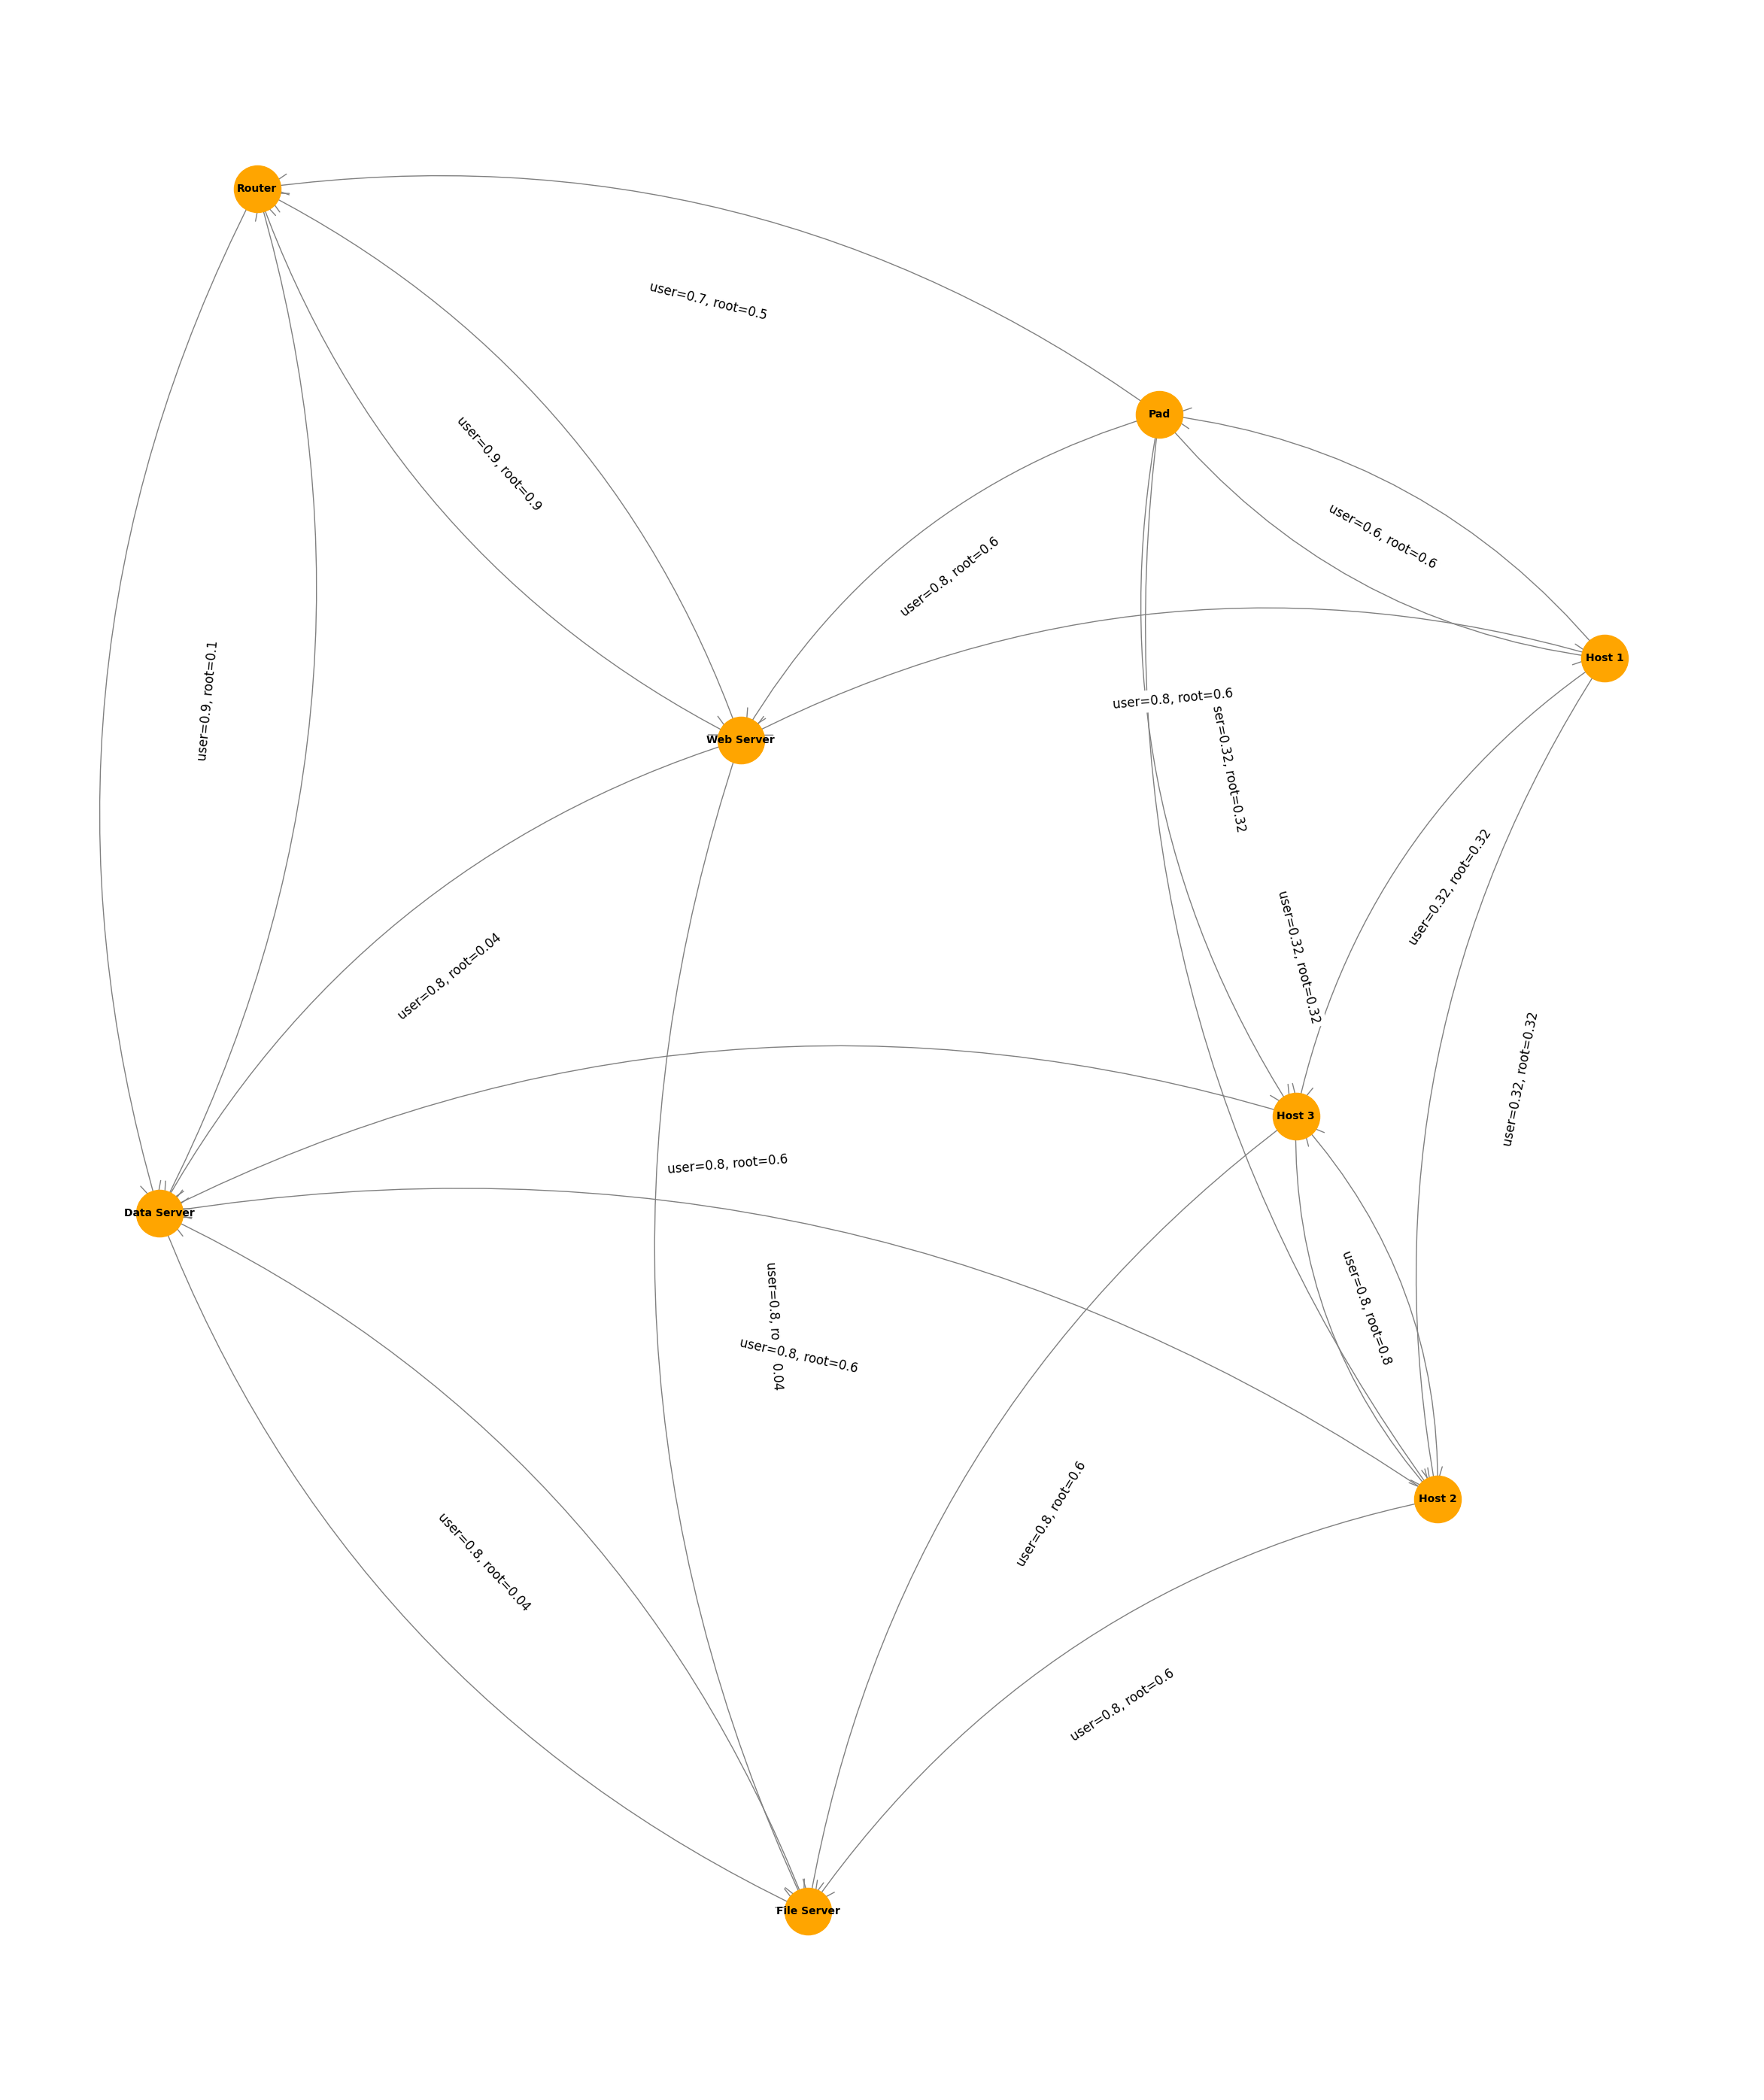

In [8]:
# --- Trực quan hóa đồ thị gốc (từ cell cũ) ---
plt.figure(figsize=(30, 36))
pos = nx.spring_layout(G_original) # Dùng G_original

nx.draw_networkx_nodes(G_original, pos, node_color='orange', node_size=2000)
nx.draw_networkx_labels(G_original, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G_original, pos,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=50,
    connectionstyle='arc3,rad=0.2'
)

# Vẽ nhãn trên cạnh
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G_original.edges(data=True)}
nx.draw_networkx_edge_labels(G_original, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.show()